# Tweets sentiment analysis

### Importing the libraries

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision

import cv2
import matplotlib.pyplot as plt

import numpy as np
from sklearn.model_selection import train_test_split

#MANAGEMENT PURPOSES ONLY-
from tqdm.notebook import tqdm
import gc
gc.collect()
torch.cuda.empty_cache()

Set seed to ensure reproducibility

In [3]:
SEED = 32
np.random.seed(SEED)
torch.manual_seed(SEED)

Set CUDA if available

In [4]:
device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.version.cuda) 

cpu
11.3


### Load data

In [5]:
data_filepath = 'data'
images_filenames = [x[2] for x in os.walk(os.path.join(data_filepath, 'profile_matrices'))][0]


In [6]:
X = {}
for i in range(len(images_filenames)):
    X[i] = np.load(os.path.join(data_filepath, 'profile_matrices', str(i)+'.npy'))

In [7]:
y = np.load('./data/y.npy')

In [8]:
y

array([1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,

In [9]:
X[0].shape

(200, 768)

In [10]:
len(X)

420

In [11]:
len(y)

420

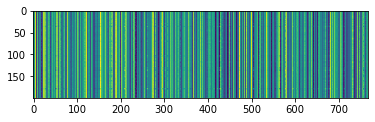

In [12]:
plt.imshow(X[0])

In [13]:
max_image_side = max([max(X[x].shape)for x in X])

In [14]:
def resize_image(image, desired_size=max_image_side):
    image = cv2.resize(image, (desired_size, desired_size), interpolation=cv2.INTER_AREA)
    return torch.tensor(image, dtype=torch.float32).unsqueeze(dim=0)

In [15]:
def one_hot_encode(y, n_classes=2):
    y_one_hot = np.zeros((len(y), n_classes))
    for i in range(len(y)):
        y_one_hot[i, y[i]] = 1
    return y_one_hot

In [16]:
y = one_hot_encode(y)

In [17]:
for i in range(len(X)):
    X[i] = resize_image(X[i], desired_size=200)
    y[i] = torch.tensor(y[i], dtype=torch.int32)

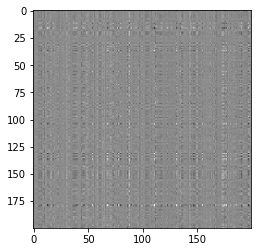

In [18]:
plt.imshow((X[0]-X[326]).numpy()[0], cmap='gray')

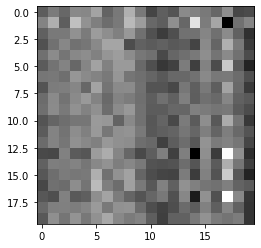

In [19]:
plt.imshow(resize_image((X[0]-X[326]).numpy()[0], desired_size=20).numpy()[0], cmap='gray')

### Create dataset

In [20]:
class Tweets(Dataset):

    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transforms = transform
        
    def __getitem__(self, index):

        X = self.X[index]
        y = self.y[index]

        if self.transforms:
            X = self.transforms(X)

        return X, y

    def __len__(self):
        return len(self.X)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [22]:
len(X_train)

336

In [23]:
len(X_test)

84

Data augmentation by randomly swapping the order of the tweets in a profile

In [24]:
swap_random_rows = lambda x: x[torch.randperm(x.shape[0])]

In [25]:
data_aug = torchvision.transforms.Compose([
    swap_random_rows,
    ])

## Hyperparameters

In [26]:
BACH_SIZE = 4
LEARNING_RATE = 1e-3
EPOCHS = 1

In [27]:
num_workers = 0
train_loader = DataLoader(Tweets(X_train, y_train, transform=data_aug), batch_size=BACH_SIZE, num_workers=num_workers, shuffle=True)
test_loader = DataLoader(Tweets(X_test, y_test, transform=data_aug), batch_size=BACH_SIZE, num_workers=num_workers, shuffle=False)

### Create model

In [28]:
# REVISAR CAPAS POR QUE ES MUY RARO QUE FUNCIONE
class TweetSentimentModel(nn.Module):
    def __init__(self):
        super(TweetSentimentModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv7 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1)
        self.conv8 = nn.Conv2d(1024, 2048, kernel_size=3, stride=1, padding=1)

        self.fc1 = nn.Linear((2048*25*25), 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 2)
    
    def forward(self, x, training=True):
        x = F.relu(self.conv1(x))
        x = F.dropout(x, p=0.1, training=training)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv3(x))
        x = F.dropout(x, p=0.1, training=training)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv5(x))
        x = F.dropout(x, p=0.1, training=training)
        x = F.relu(self.conv6(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv7(x))
        x = F.dropout(x, p=0.1, training=training)
        x = F.relu(self.conv8(x))
        x = x.view(BACH_SIZE, 2048*25*25)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.log_softmax(model.fc5(x), -1) # -1 is the last dimension to apply the log_softmax over
        return x


In [29]:
model = TweetSentimentModel().to(device)
optimizer = AdamW(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [30]:
def one_hot_encode(y, num_classes):
    num_samples = y.shape[0]
    y_one_hot = torch.zeros((num_samples, num_classes))

    for i in range(num_samples):
        y_one_hot[i, y[i].int()-1] = 1   
    
    return y_one_hot

In [31]:
def get_accuracy(predictions, y):
    return (predictions.argmax(dim=1) == y).float().mean().item()

In [32]:
def evaluate_model(model, data_loader):
    
    model.eval()
    
    total_loss = 0
    total_accuracy = 0

    with torch.no_grad():
        for batch in data_loader:
            X, y = batch
            y = one_hot_encode(y, 2)
            predictions = model(X, training=False)
            loss = criterion(predictions, y)
            total_loss += loss.item()
            total_accuracy += get_accuracy(predictions, y)

    accuracy = total_accuracy / len(data_loader)
    loss = total_loss / len(data_loader)

    model.train()

    return accuracy, loss

In [33]:
X_batch, y_batch = next(iter(train_loader))
X_batch = X_batch.to(device)
y_batch = y_batch.to(device)

In [34]:
for epoch in range(1):
    for step, (profiles, labels) in tqdm(enumerate(train_loader)):
        
        labels = labels.to(device)
        output = model(profiles, training=True)

        loss = criterion(output, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acuracy, loss = evaluate_model(model, test_loader)

        print(f'Epoch: {epoch+1:02} | Step: {step+1:02} | Loss: {loss:.4f} | Accuracy: {acuracy*100:.2f}%')
    

0it [00:00, ?it/s]

RuntimeError: [enforce fail at C:\cb\pytorch_1000000000000\work\c10\core\impl\alloc_cpu.cpp:81] data. DefaultCPUAllocator: not enough memory: you tried to allocate 5242880000 bytes.

In [ ]:
evaluate_model(model, test_loader)